In [2]:
# https://stackoverflow.com/questions/71239557/export-tensorboard-with-pytorch-data-into-csv-with-python

import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

if False:
    path="runs/Hopper-v4__ppo_continuous_action__1__1701623044" #folderpath
    df=tflog2pandas(path)
    df.to_csv("output.csv")

    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.plot(df[df['metric'] == 'charts/episodic_return'].set_index('step')['value'])

In [8]:
    # path="runs/Hopper-v4__ppo_continuous_action__1__1701623044" #folderpath
    # df=tflog2pandas(path)
from glob import glob

all_files = glob("runs/*/*.0")

In [53]:
df = []

for f in all_files:
    tmp_df=tflog2pandas(f)
    tmp_df = tmp_df[tmp_df['metric'] == 'eval/episodic_return']
    tmp_df['label'] = f.split('/')[1]
    df.append(tmp_df)


df = pd.concat(df)

In [54]:
def map_label(x):
    if '200-to-400-no-reset' in x:
        return 'Frames 200k-400k No Resets'
    elif '200-to-400-reset-last-layer-of-actor' in x:
        return 'Frames 200k-400k Reset Actor'
    elif '200-to-400-reset-last-layer-of-critic' in x:
        return 'Frames 200k-400k Reset Critic'
    else:
        return 'Frames 0-200K'


In [55]:
df['Experiment'] = df['label'].map(map_label)

In [56]:
# df.groupby('label').value.agg(['mean', 'std'])

import seaborn as sns
%matplotlib inline

<Axes: xlabel='Episodic Return', ylabel='Experiment'>

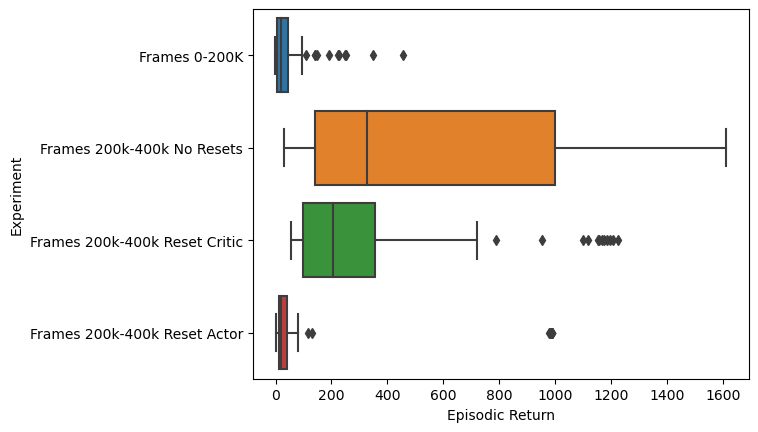

In [57]:
sns.boxplot(data=df.rename(columns={'value':'Episodic Return'}), x="Episodic Return", y="Experiment")


In [52]:
df.groupby('label').mean()

,value,step
label,,
Frames 0-200K,44.558592,4.5
Frames 200k-400k No Resets,549.058790,4.5
Frames 200k-400k Reset Actor,139.743624,4.5
Frames 200k-400k Reset Critic,325.882986,4.5
